In [1]:
import numpy as np

yaw = 20
pitch = 40
roll = 10

In [2]:
from scipy.spatial.transform import Rotation as R

phi = np.deg2rad(yaw)
theta = np.deg2rad(90-pitch)
x = np.sin(theta) * np.cos(phi)
y = np.sin(theta) * np.sin(phi)
z = np.cos(theta)

In [3]:

# construct the camera at x = 1 and rotate it so correctly points at origin
cam_point = np.array([1,0,0])
init_cam_rot = R.from_euler('zy', [90,-90], degrees=True)
rotated_cam_point = init_cam_rot.apply(cam_point) # gives same point as rotate camera using euler angle

obj_point = np.array([0,0,0])
obj_rotation = R.from_euler('yzx', [-pitch, yaw, -roll], degrees=True)
obj_rotation.apply(obj_point) # gives same point as rotate object using euler angle

inv_obj_rotation = R.from_matrix(obj_rotation.inv().as_matrix())
new_cam_point = inv_obj_rotation.apply(cam_point)
camera_rot = inv_obj_rotation * init_cam_rot
camera_rot_quat = camera_rot.as_quat()
combined_pose = np.append(new_cam_point, camera_rot_quat) # np

In [4]:
camera_rot_quat

array([-0.38808583, -0.21766489,  0.51749535,  0.73089668])

In [5]:
%matplotlib widget
import matplotlib.pyplot as plt
import pytransform3d.camera as pc
import pytransform3d.transformations as pt


cam2world = pt.transform_from_pq(combined_pose)
# default parameters of a camera in Blender
sensor_size = np.array([0.036, 0.024])
intrinsic_matrix = np.array([
    [0.05, 0, sensor_size[0] / 2.0],
    [0, 0.05, sensor_size[1] / 2.0],
    [0, 0, 1]
])
virtual_image_distance = 1

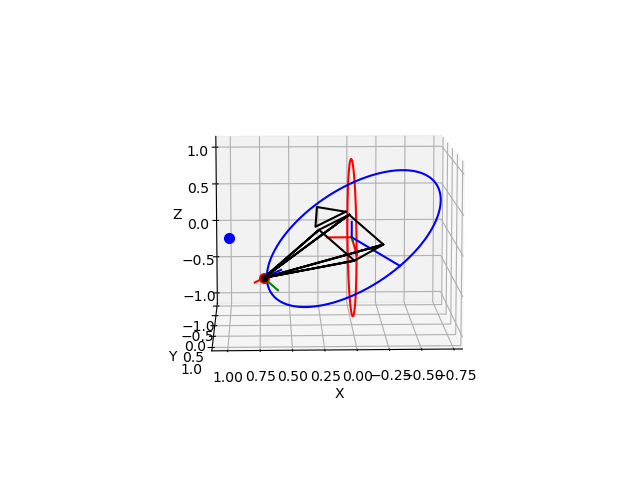

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# https://machinelearning1.wordpress.com/2019/05/27/quaternions-use-them-for-rotation-and-transformation/
s = np.linspace(0,2*np.pi,100)
y = np.append(np.cos(s),0)
z = np.append(np.sin(s),0)
x = np.zeros_like(y)
P = np.stack((x,y,z)).T
Pr = np.zeros_like(P)
for i in range(len(s)):
    Pr[i][:] = obj_rotation.apply([x[i], y[i], z[i]])

plt.close('all')
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
for idx, f in enumerate([P, Pr]):
    ax.plot(f[:,0],f[:,1],f[:,2],zdir='z',label=f'{idx}', c=['red', 'blue'][idx])
plt.plot(cam_point[0],cam_point[1],cam_point[2],'o',label='cam',markersize=7, c='blue')
plt.plot(new_cam_point[0], new_cam_point[1],new_cam_point[2],'o',label='new cam',markersize=7, c='red')
# scipy makes x, y, z, w, BUT w,x,y,z is how to visualise
cam2world = pt.transform_from_pq(np.append(new_cam_point, np.roll(camera_rot_quat, 1)))
pt.plot_transform(ax=ax, A2B=cam2world, s=0.2)
pt.plot_transform(ax=ax, A2B=pt.transform_from(np.eye(3), np.zeros((3))), s=0.2)
pc.plot_camera(
    ax, cam2world=cam2world, M=intrinsic_matrix, sensor_size=sensor_size,
    virtual_image_distance=virtual_image_distance)
ax.view_init(elev=9, azim=88)
plt.show()

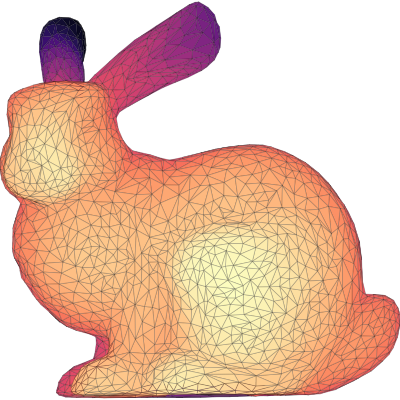

In [7]:
import numpy as np
from mpl3d import glm
from mpl3d.mesh import Mesh
from mpl3d.camera import Camera
import matplotlib.pyplot as plt
import meshio

fig = plt.figure(figsize=(4,4))
ax = fig.add_axes([0,0,1,1], xlim=[-1,+1], ylim=[-1,+1], aspect=1)
ax.axis("off")

camera = Camera("ortho", scale=2)
mesh = meshio.read("data/bunny.obj")
vertices = mesh.points
faces = mesh.cells[0].data
vertices = glm.fit_unit_cube(vertices)
mesh = Mesh(ax, camera.transform, vertices, faces,
            cmap=plt.get_cmap("magma"),  edgecolors=(0,0,0,0.25))
camera.connect(ax, mesh.update)
plt.savefig("bunny.png", dpi=600)
plt.show()